In [1]:
import os
import numpy as np

import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

# Continue with regular imports
import matplotlib.pyplot as plt

# Try to get torchinfo for summary of model, install it if it doesn't work
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary


In [2]:
from utils.accuracy import accuracy
from utils.train_test import *

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Datatransforms

In [4]:
# All models are pretrained on IMAGENET1K

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets

In [5]:
DATA_DIR = 'brain_dataset'
SPLIT_RATIO = 0.8

# Import dataset
dataset = datasets.ImageFolder(root=DATA_DIR)

# Split dataset
train_size = int(SPLIT_RATIO * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#Assign transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

classes = dataset.classes
len(train_dataset), len(test_dataset), classes

(201, 51, ['no', 'yes'])

# Dataloaders

In [6]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1d9af14a090>,
 <torch.utils.data.dataloader.DataLoader at 0x1d9d1bb2110>)

# Examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

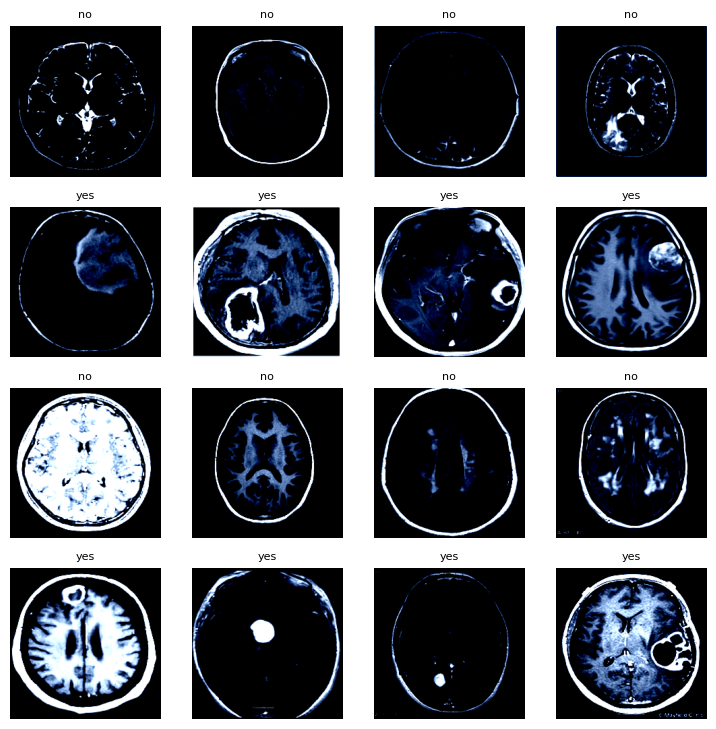

In [7]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
  image, true_label = train_dataset[random_idx]

  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0), cmap="gray")

  plt.title(f"{classes[true_label]}", fontsize=8)
  plt.axis(False)

# Models

In [8]:
models = {"AlexNet": {"model": torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights.IMAGENET1K_V1), "train_losses": [], "test_losses": [], "accuracies": [], "conf_mat": [], "time": 0},
         "EffNet_B0": {"model": torchvision.models.efficientnet_b0(weights=torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1), "train_losses": [], "test_losses": [], "accuracies": [], "conf_mat": [], "time": 0},
         "MobileNet_V3": {"model": torchvision.models.mobilenet_v3_large(weights=torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V2), "train_losses": [], "test_losses": [], "accuracies": [], "conf_mat": [], "time": 0},
         "ResNet50": {"model": torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2), "train_losses": [], "test_losses": [], "accuracies": [], "conf_mat": [], "time": 0},
         "VGG16": {"model": torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1), "train_losses": [], "test_losses": [], "accuracies": [], "conf_mat": [], "time": 0},
         "ViT": {"model": torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT), "train_losses": [], "test_losses": [], "accuracies": [], "conf_mat": [], "time": 0}
         }

# Model

In [9]:
weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
model = torchvision.models.resnet50(weights=weights)
model.to(device)
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [10]:
summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 1000]            --                   True
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      4,096                True
│    │    └─BatchN

# Freezing

In [11]:
for param in model.conv1.parameters():
  param.requires_grad = False

for param in model.bn1.parameters():
  param.requires_grad = False

for param in model.layer1.parameters():
  param.requires_grad = False

for param in model.layer2.parameters():
  param.requires_grad = False

for param in model.layer3.parameters():
  param.requires_grad = False

for param in model.layer4.parameters():
  param.requires_grad = False

#summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

# Head Update

In [12]:
model.fc = nn.Sequential(nn.Dropout(p=0.2, inplace=True), nn.Linear(2048, 1))

In [13]:
summary(model=model, input_size = (1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 1]               --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

# Loss function and optimizer

In [14]:
loss_fn = nn.BCEWithLogitsLoss()

#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train

In [15]:
from tqdm.auto import tqdm
import time

train_losses = []
test_losses = []
test_accuracies = []

In [16]:
EPOCHS = 30

program_starts = time.time()
for epoch in tqdm(range(EPOCHS)):
  train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
  test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)

  train_losses.append(train_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  print(f"Epoch: {epoch+1} | Training Loss: {train_loss} | Test Loss: {test_loss} | Test acc: {test_accuracy}%")


program_ends = time.time()

print(f"Elapsed: {program_ends-program_starts}s")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | Training Loss: 0.6619663238525391 | Test Loss: 0.62457674741745 | Test acc: 62.745098039215684%
Epoch: 2 | Training Loss: 0.6042295694351196 | Test Loss: 0.5919554829597473 | Test acc: 62.745098039215684%
Epoch: 3 | Training Loss: 0.5748257637023926 | Test Loss: 0.5689716935157776 | Test acc: 62.745098039215684%
Epoch: 4 | Training Loss: 0.5533092021942139 | Test Loss: 0.5592483878135681 | Test acc: 64.70588235294117%
Epoch: 5 | Training Loss: 0.5265311002731323 | Test Loss: 0.5585898160934448 | Test acc: 72.54901960784314%
Epoch: 6 | Training Loss: 0.509809672832489 | Test Loss: 0.5521832704544067 | Test acc: 84.31372549019608%
Epoch: 7 | Training Loss: 0.4802744686603546 | Test Loss: 0.5276823043823242 | Test acc: 86.27450980392157%
Epoch: 8 | Training Loss: 0.4548742175102234 | Test Loss: 0.4923161268234253 | Test acc: 84.31372549019608%
Epoch: 9 | Training Loss: 0.4386633634567261 | Test Loss: 0.4721498191356659 | Test acc: 84.31372549019608%
Epoch: 10 | Training Loss: 0

# Plot

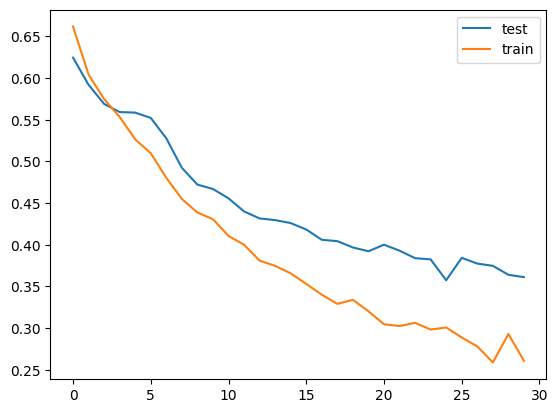

In [17]:
plt.plot(test_losses, label="test")
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

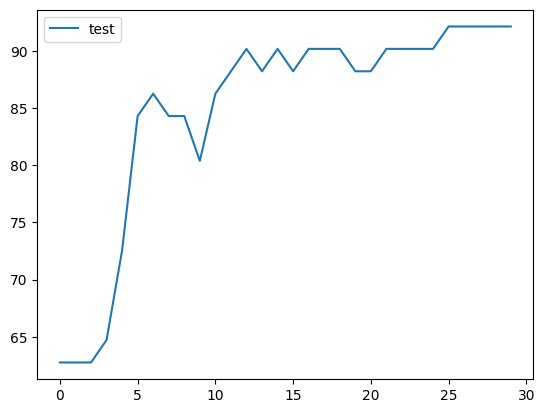

In [18]:
#plt.plot(train_accuracies, label="train")
plt.plot(test_accuracies, label="test")
plt.legend()
plt.show()

## Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

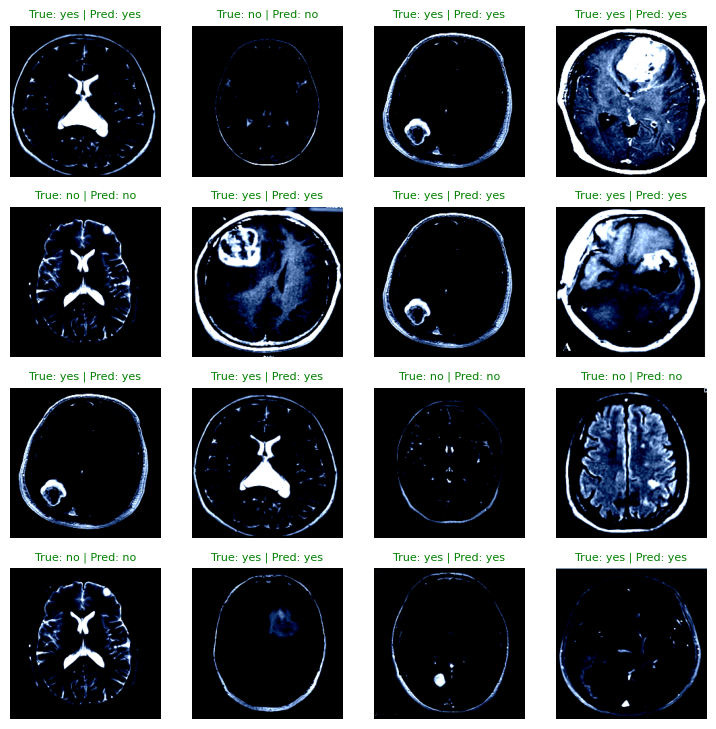

In [19]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
  image, true_label = test_dataset[random_idx]

  predicted_label = model(image.unsqueeze(dim=0).to(device))
  predicted_label = (predicted_label > 0).int().squeeze()

  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0), cmap="gray")
  if true_label == predicted_label:
    color = "g"
  else:
    color = "r"
  plt.title(f"True: {classes[true_label]} | Pred: {classes[predicted_label]}", fontsize=8, c=color)
  plt.axis(False)

## Confusion matrix

  0%|          | 0/51 [00:00<?, ?it/s]

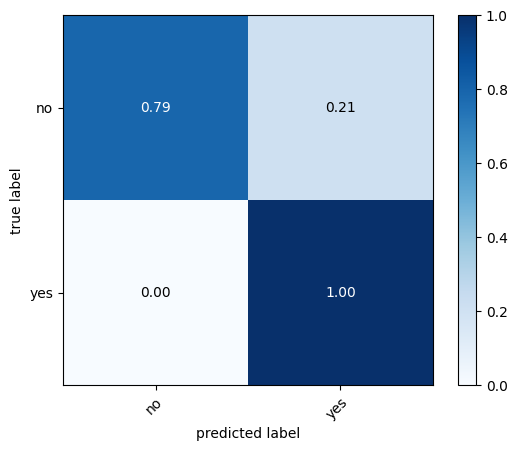

In [20]:
try:
  from torchmetrics import ConfusionMatrix
except:
  !pip install torchmetrics
  from torchmetrics import ConfusionMatrix

try:
  from mlxtend.plotting import plot_confusion_matrix
except:
  !pip install mlxtend
  from mlxtend.plotting import plot_confusion_matrix

y_preds = []
true_labels = []

for i in tqdm(range(len(test_dataset))):
  image, true_label = test_dataset[i]
  predicted_label = model(image.unsqueeze(dim=0).to(device))
  predicted_label = (predicted_label > 0).int().squeeze()
  y_preds.append(predicted_label)
  true_labels.append(true_label)

y_preds = torch.tensor(y_preds).squeeze()
true_labels = torch.tensor(true_labels).squeeze()

confmat = ConfusionMatrix(task="multiclass", num_classes=2)
matrix = np.array(confmat(y_preds, true_labels))

fig, ax = plot_confusion_matrix(conf_mat=matrix, colorbar=True, show_absolute=False, show_normed=True, class_names=classes)
plt.show()

In [21]:
print([loss.item() for loss in train_losses])
print([loss.item() for loss in test_losses])
print(test_accuracies)
print([[int(i) for i in row]for row in matrix])

[0.6619663238525391, 0.6042295694351196, 0.5748257637023926, 0.5533092021942139, 0.5265311002731323, 0.509809672832489, 0.4802744686603546, 0.4548742175102234, 0.4386633634567261, 0.430671751499176, 0.4105030596256256, 0.4000454246997833, 0.38088518381118774, 0.37463897466659546, 0.3656739592552185, 0.3529577851295471, 0.3399922549724579, 0.32900160551071167, 0.33387523889541626, 0.32009318470954895, 0.30453839898109436, 0.3024023473262787, 0.30620524287223816, 0.2981986105442047, 0.3006417453289032, 0.2886548638343811, 0.27797895669937134, 0.25865644216537476, 0.29289326071739197, 0.26068541407585144]
[0.62457674741745, 0.5919554829597473, 0.5689716935157776, 0.5592483878135681, 0.5585898160934448, 0.5521832704544067, 0.5276823043823242, 0.4923161268234253, 0.4721498191356659, 0.46691179275512695, 0.45568370819091797, 0.43995803594589233, 0.4315570592880249, 0.4295344650745392, 0.42597416043281555, 0.41825321316719055, 0.4059343636035919, 0.40427878499031067, 0.3967171609401703, 0.392